In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load libraries

In [27]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [28]:
from tqdm.auto import tqdm

import tensorflow as tf
import numpy as np
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from glob import glob
from utils import *
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import scipy.interpolate as scp
from scipy.optimize import curve_fit

from datasets import load_dataset

### Select the metric

For this example code, we are going to use the RMSE metric, but you can use any metric you like. By changing the cell below, you can define one of your own, use one of your own or any other metric already defined. If you call it <sample_metric> you don't have to change anything else in the code. If you call it something else, you will have to change all calls to <sample_metric> to whatever name you have given it. 

In [29]:
def sample_metric(img1, img2):
    return ((img1 - img2)**2).mean(axis=(1,2,3))**(1/2)

# Transduction function

We will follow the order of the paper, so the first step is to define the transduction function. The transduction function is, in turn, composed of two functions. First, we will calculate the response function, which is the distance returned by the selected metric for the image pairs (original-distorted). Then, we will calculate the equalisation function, for which we need a subjectively rated database (in our case, TID2013).

## Response function

So that you can create your own pairs of images (original, distorted), we will show you how to use the functions we have generated ourselves to modify the images in the databases. 

First, we load any image and divide it so that it is in the interval [0,1].

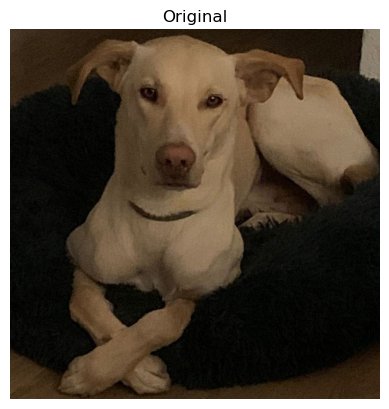

In [30]:
baldur = io.imread("Baldur.jpeg")
baldur = baldur/255.

plt.imshow(baldur)
plt.title("Original")
plt.axis("off")
plt.show()

### Mosaic

With the *create_mosaic* function we will generate the mosaic to avoid edge artefacts without having to resort to black borders or strange fills. 

**Note: All the information about the function parameters is explained in utils.py**



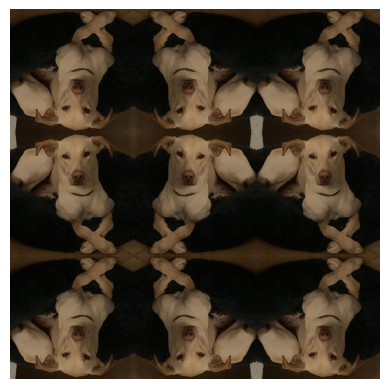

In [31]:
baldur_mosaico = create_mosaic(baldur[None,:,:,:])[0]
plt.imshow(baldur_mosaico)
plt.axis("off")
plt.show()

### Traslacion

The *translation2* function translates the image by the desired number of pixels. As the input image is that of the previously created mosaic, the new pixels entering the image are from the image itself, avoiding artefacts (this is why mosaicking is useful). Then a crop is performed so that the final image is the same size as the original image. 

There is also a *translation* function intended for black and white images, with only one channel.

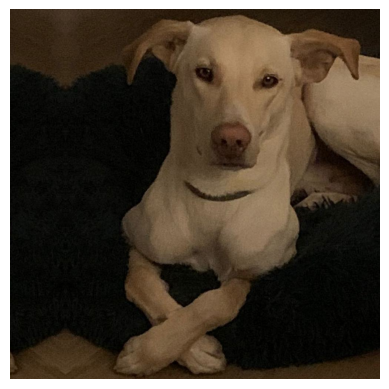

In [32]:
baldur_tras = traslation2(baldur_mosaico[None,:,:,:],(1000,1000),0,-150)[0]
plt.imshow(baldur_tras)
plt.axis("off")
plt.show()

### Rotation

The *rotation2* function rotates the image by the desired number of degrees. A crop is then performed so that the final image is the same size as the original image. 

There is also a *rotation* function for black and white images, with only one channel.

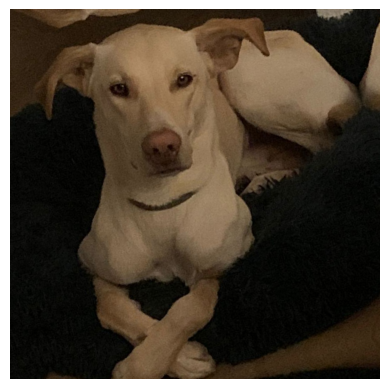

In [33]:
baldur_rot = rotation2(baldur_mosaico,(1000,1000),15)
plt.imshow(baldur_rot)
plt.axis("off")
plt.show()

### Scale

The *scale_mosaic* function scales the image by a desired scale factor. In this case, it is important to take into account the possible scaling factors supported by the image size we are manipulating. Note that the input image to this function is not the mosaic, but the original image. It was simpler for the function to make the mosaic inside.

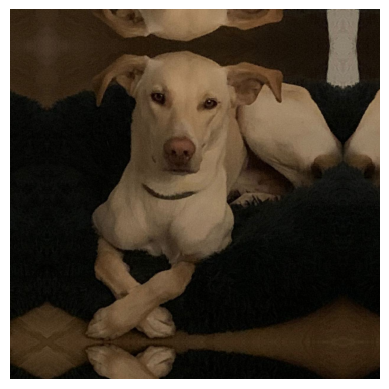

In [34]:
baldur_esc = scale_mosaic(baldur[None,:,:,:], escala = 0.8, size = (1000,1000))[0]
baldur_esc.shape
plt.imshow(baldur_esc)
plt.axis("off")
plt.show()

#### All together

Finally, we show all the examples together. You can do your own tests and find the values for the degrees of translation, rotation and scale factor, for which you see all 4 pictures the same!

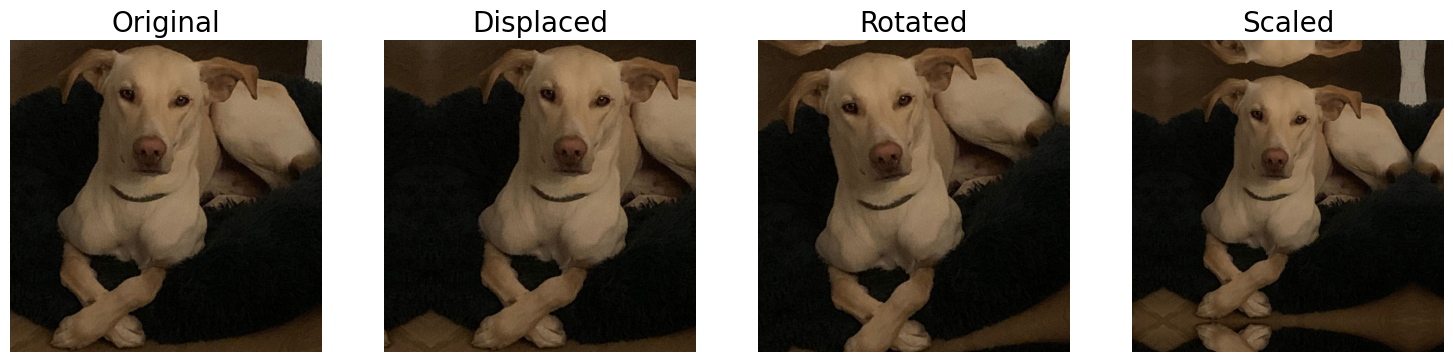

In [35]:
font = 20

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
f.set_size_inches(18.5, 10.5)
ax1.set_title("Original",
          fontsize = font)
ax1.imshow(baldur, cmap = "gray")
ax2.set_title("Displaced",
          fontsize = font)
ax2.imshow(baldur_tras, cmap = "gray")
ax3.set_title("Rotated",
          fontsize = font)
ax3.imshow(baldur_rot, cmap = "gray")
ax4.set_title("Scaled",
          fontsize = font)
ax4.imshow(baldur_esc, cmap = "gray")

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")

plt.show()

### Pass original-distorted image pairs through the metric 

Once we know how to use the functions that modify the original image, it remains to see what the metric returns for these distorted images. In the previous examples, we have used any image, but from now on we will use an image from the ImageNet database, the image of the horse shown below.

The datasets with the images related to the illuminant changes can be found here:

https://huggingface.co/datasets/Rietta5/Databases_IlluminantChanges

And an example of adjustment and processing of the illuminant change data, at Fit_Ellipses_TID.ipynb

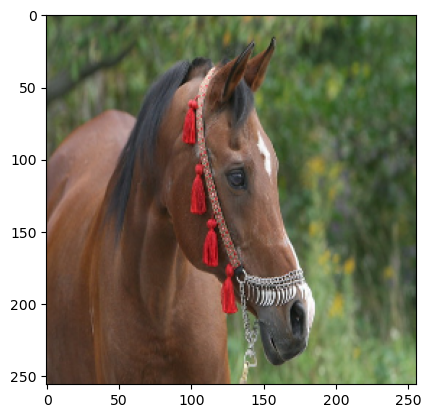

In [36]:
im = io.imread("im178.png")
im = im/255.
plt.imshow(im)
plt.show()

The way to proceed is always the same, changing the function you are going to use. You first define the range of distortions you are going to apply to the images in the variables *desp_h,desp_v,rotations,scales* and the images on which you are going to apply them. For each image read, you first apply the function without applying changes, i.e. you keep the original image, and then you apply the changes, the distorted image. Once we have both, we calculate the metric value for that pair of images and save them. If you pass more than one image, you will have to average the values returned.

In [37]:
dst_train = create_mosaic(im[None,:,:,:])

distances_tras = []
distances_rot = []
distances_sc = []


# Traslation________________________________________________________________________________

desps_h = range(-10,11)
desps_v = range(-10,11)

for desp_h in desps_h:
    for desp_v in desps_v:
        for img in dst_train:    
            img_desp = traslation2(img[None,:,:,:], crop = (256,256), desp_h = desp_h, desp_v = desp_v)
            img = traslation2(img[None,:,:,:], crop = (256,256), desp_h=0, desp_v=0)

            met = sample_metric(img.numpy(), img_desp.numpy())
            distances_tras.append(met)

# Rotation________________________________________________________________________________

rotations = np.arange(0,11, 0.1)
for rotation in rotations:
    for img in dst_train:
        img_desp = rotation2(img, rotacion = rotation, crop = (384,512))
        img = rotation2(img, rotacion=0, crop = (384,512))


        met = sample_metric(img[None,:,:,:], img_desp[None,:,:,:])
        distances_rot.append(met)


# Scale________________________________________________________________________________
scales = pd.read_csv("escalas_imagenet.csv")
scales = scales["0"]

dsts_escalas = {}
for escala in scales:
    dst_train = scale_mosaic(dst_train, 1, size = (256,256), batch = 100)
    dsts_escalas = scale_mosaic(dst_train, escala, size = (256,256), batch = 100)
    for img, img_desp in zip(dst_train, dsts_escalas):    
        met = sample_metric(img.numpy()[None,:,:,:],img_desp.numpy()[None,:,:,:])
        distances_sc.append(met)



Those values ​​that we have saved with the iterations are the response function:

$$d_M(\theta) = \frac{1}{S} \sum_{s=1}^{S} d_M(i^s,T_\theta(i^s))$$

## Equalization function



### Load TID13

We load a database with a rating, in our case TID13, but it can be any other database.


In [38]:
TID13 = load_dataset("jorgvt/TID2013", num_proc = 8, trust_remote_code=True)

distances, moses = [], []
for batch in tqdm(TID13["train"].with_format("numpy").iter(batch_size=64)):
    dist = sample_metric(batch["reference"]/255, batch["distorted"]/255)
    distances.extend(dist)
    moses.extend(batch["mos"])

TID13 = pd.DataFrame()
TID13["SampleMetric"] = distances
TID13["MOS"] = moses
TID13["DMOS"] =  (10 - TID13["MOS"])/10

0it [00:00, ?it/s]

We plot the distances returned by our metric as a function of DMOS to get an idea of the result.

Text(0.5, 1.0, 'SampleMetric')

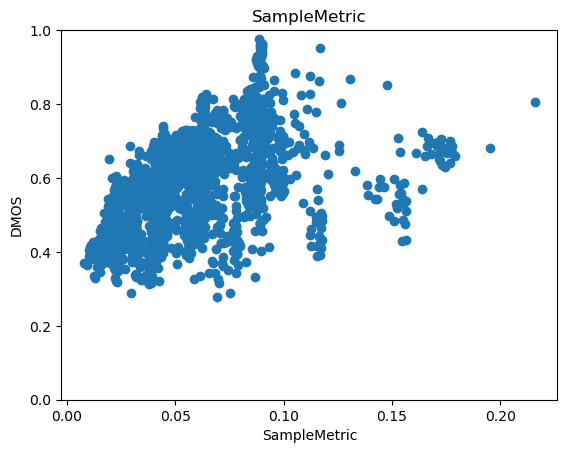

In [39]:
plt.plot(TID13["SampleMetric"], TID13["DMOS"], "o")
plt.ylim([0,1])
plt.xlabel(f"SampleMetric")
plt.ylabel("DMOS")
plt.title("SampleMetric")

The objective is to fit an affunction of the type: $$ a_M\cdot  d_M(i,i')^{b_M}  $$

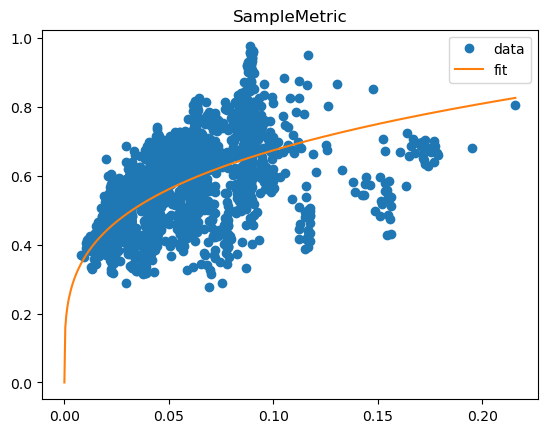

In [40]:
fs_pot = []

def pot(x, a, b):
    y = a * x**b
    return (y)

xdata =  TID13["SampleMetric"]
ydata = TID13["DMOS"]


p0 = [1, 1/2] # this is an mandatory initial guess
popt, pcov = curve_fit(pot, xdata, ydata,p0, method='dogbox')
fs_pot.append([*popt])

x = np.linspace(0, max(TID13["SampleMetric"]), 500)
y = pot(x, *popt)

# interpol = scp.interp1d(y,x, bounds_error=False)
# interpols = interpol(0.44)
# print(interpols)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
plt.title("SampleMetric")
plt.show()

In [41]:
fs_pot

[[1.2398322071369559, 0.2645684248720596]]

These will be the coefficients of the equalisation function: 
$$\mathcal{D} = f_M( d_M(i,i') ) = a_M\cdot  d_M(i,i')^{b_M}$$

# Metric threshold and final comparison

We composite the response and equalisation function and interpolate the cut-off points corresponding to the threshold in the inner domain. We then check whether the calculated confidence interval coincides with the measured human threshold.

## Translation Results

[0.0262418  0.02994257 0.03357605]


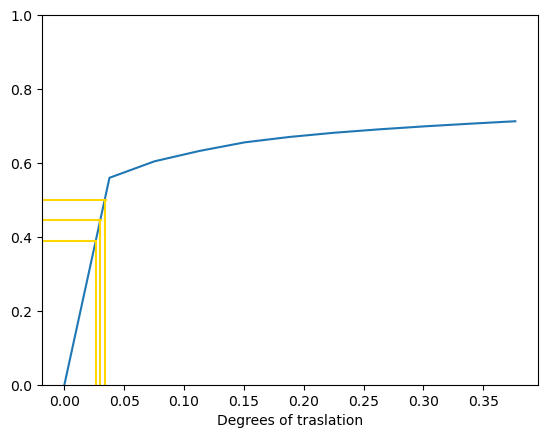

In [42]:
c =  pot(distances_tras,*fs_pot[0])
c = np.array(c)

m = c.reshape(21,21)
y = ((m[10,:] + m[:,10])/2)[10:21]
x = np.linspace(0,11,11)/29.2

interpol = scp.interp1d(y[0:11], x[0:11],  bounds_error=False)
interpols = interpol([0.390,0.445,0.499])
interpols = np.append(interpols,((interpols[2] - interpols[0])/2))
print(interpols[0:3])


ax = plt.gca()
plt.ylim([0, 1])
#plt.axvline(0, c = "red")  
    
plt.plot((np.linspace(0,11,11)/29.2), ((m[10,:] + m[:,10])/2)[10:21], '-')
plt.xlabel("Degrees of traslation")


plt.axhline(0.390, c = "gold", xmax = 0.11) 
plt.axhline(0.445, c = "gold", xmax = 0.12) 
plt.axhline(0.499, c = "gold", xmax = 0.13) 


plt.axvline(0.0262418, c = "gold", ymax = 0.390) 
plt.axvline(0.02994257, c = "gold", ymax = 0.445) 
plt.axvline(0.03357605, c = "gold", ymax = 0.499) 

plt.show()

In [43]:
print(interpols[1], interpols[-1])

0.029942567318703497 0.003667123413189529


Human threshold: 0.23 degrees

Confidence interval of the metric: $0.030 \pm 0.004$


In [44]:
(interpols[1] - interpols[-1])< 0.23 and (interpols[1] + interpols[-1])> 0.23

False

## Rotation Results

[0.09432638 0.14194144 0.22429065]


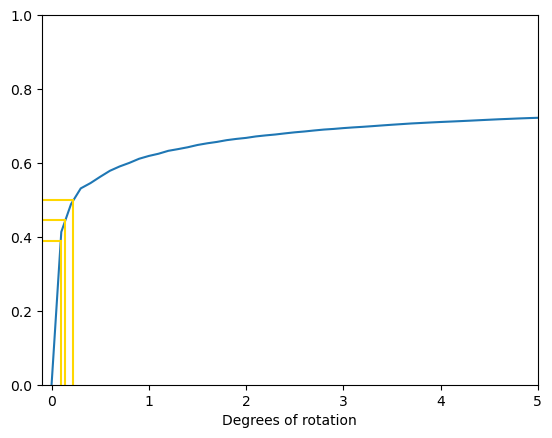

In [45]:
c = pot(distances_rot,*fs_pot[0])
c = np.array(c)

plt.plot(np.arange(0,11, 0.1),c,"-")

y = c
x = np.arange(0,11, 0.1)

interpol = scp.interp1d(y.ravel(), x,  bounds_error=False)
interpols = interpol([0.390,0.445,0.499])
interpols = np.append(interpols,((interpols[2] - interpols[0])/2))
print(interpols[0:3])


plt.axhline(0.390, c = "gold", xmax = 0.039) 
plt.axhline(0.445, c = "gold", xmax = 0.045) 
plt.axhline(0.499, c = "gold", xmax = 0.06) 


plt.axvline(0.09432638, c = "gold", ymax = 0.390) 
plt.axvline(0.14194144, c = "gold", ymax = 0.445) 
plt.axvline(0.22429065, c = "gold", ymax = 0.499) 

plt.xlim([-0.1, 5])
plt.ylim([0, 1])
plt.ylabel("")
plt.xlabel("Degrees of rotation")
plt.show()

In [46]:
print(interpols[1], interpols[-1])

0.14194144300077216 0.06498213728616277


Human threshold: 3.6 degrees

Confidence interval of the metric: $0.14 \pm 0.06$

In [47]:
(interpols[1] - interpols[-1])< 3.6 and (interpols[1] + interpols[-1])> 3.6

False

## Scale Results

[1.00823114 1.00939195 1.01494602]


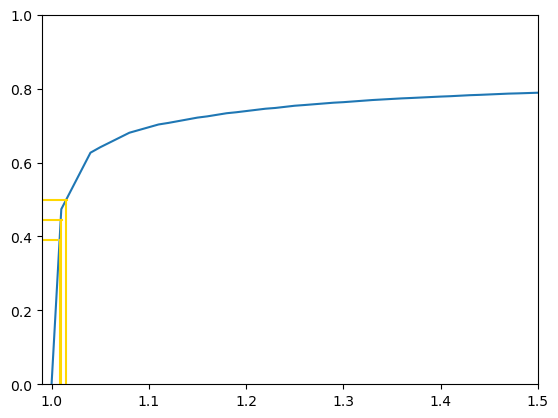

In [48]:
c =  pot(distances_sc,*fs_pot[0])
c = np.array(c)


plt.plot(scales[47:],c[47:],'-')

y = c[47:]
x = scales[47:]

interpol = scp.interp1d(y.ravel(), x,  bounds_error=False)
interpols = interpol([0.390,0.445,0.499])
interpols = np.append(interpols,((interpols[2] - interpols[0])/2))
print(interpols[0:3])


plt.axhline(0.390, c = "gold", xmax = 0.03) 
plt.axhline(0.445, c = "gold", xmax = 0.04) 
plt.axhline(0.499, c = "gold", xmax = 0.05) 


plt.axvline(1.00823114, c = "gold", ymax = 0.390) 
plt.axvline(1.00939195, c = "gold", ymax = 0.445) 
plt.axvline(1.01494602, c = "gold", ymax = 0.499) 

plt.ylim([0, 1])
plt.xlim([0.99, 1.5])
plt.show()

In [49]:
print(interpols[1], interpols[-1])

1.0093919452947377 0.003357438179785177


Human threshold: 1.026 degrees

Confidence interval of the metric: $1.009 \pm 0.003$

In [50]:
(interpols[1] - interpols[-1])<1.026 and (interpols[1] + interpols[-1])>1.026

False